In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
import similaritymeasures
%matplotlib inline


/Users/jpeg/code/collimator-ai/lane-keeping-demo/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from single_test import load_model, infer
model, device = load_model()

Loaded pretrained weights for efficientnet-b0


img size 640 360
found new candidate left lane: 0
found new candidate left lane: 1
found new candidate left lane: 2
found new candidate right lane: 3
offset 0.39513049802476075


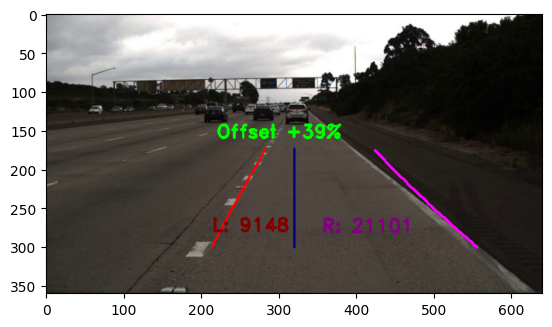

In [8]:
# poly = results[0][0][0][3:]
# x = np.linspace(0, 1, 101)
# y = np.array([np.polyval(poly, i) for i in x])
# plt.plot(x,y)

img_bgr = cv2.imread('snap2.png')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img = cv2.resize(img_rgb, (640, 360), interpolation=cv2.INTER_LINEAR)
# img = cv2.resize(img_bgr, (640, 360), interpolation=cv2.INTER_LINEAR)
# img = img_bgr
# img = np.array(img / 255., dtype=np.float)
# print(img)

h, w = img.shape[:2]
print("img size", w, h)

transform = transforms.ToTensor()
tensor = transform(img)
tensor = tensor.unsqueeze(0)
results = infer(model, tensor, device)

label = results[0][0]

lanePoints = []

for i, raw_lane in enumerate(label):
    raw_lane = raw_lane.cpu().numpy()
    if raw_lane[0] == 0:  # Skip invalid lanes
        continue

    # generate points from the polynomial
    lane = raw_lane[1:]  # remove conf
    lower, upper = lane[0], lane[1]
    lane = lane[2:]  # remove upper, lower positions
    ys = np.linspace(lower, upper, num=100)
    points = np.zeros((len(ys), 2), dtype=np.int32)
    points[:, 1] = (ys * h).astype(int)
    points[:, 0] = (np.polyval(lane, ys) * w).astype(int)
    points = points[(points[:, 0] > 0) & (points[:, 0] < w)]

    lanePoints.append(points)


leftLane = None
rightLane = None
leftLaneX = -w
leftLaneY = 0
rightLaneX = w*2
rightLaneY = 0

for k in range(len(lanePoints)):
    points = lanePoints[k]

    xBottom = points[-1][0]
    yBottom = points[-1][1]

    # We're looking for the start point that is the most to the bottom (closer to the car in Y)
    # and closest in X too.
    if xBottom < w//2 and yBottom > leftLaneY and xBottom > leftLaneX:
        print("found new candidate left lane:", k)
        leftLaneX = xBottom
        leftLaneY = yBottom
        leftLane = points
    if xBottom > w//2 and yBottom > rightLaneY and xBottom < rightLaneX:
        print("found new candidate right lane:", k)
        rightLaneX = xBottom
        rightLaneY = yBottom
        rightLane = points

    # draw lane with a polyline on the overlay (green)
    # for current_point, next_point in zip(points[:-1], points[1:]):
    #     img = cv2.line(img, tuple(current_point), tuple(next_point), color=(0, 255, 0), thickness=2)



# Center line: show where is the car going right now
nPoints = len(points)
centerX = np.ones(nPoints) * (w//2)
centerY = np.linspace(0, h, nPoints)
centerLane = np.array([[x,int(y)] for x,y in zip(centerX, centerY)], dtype=int)


# Filter the part of the lane that is actually to the left/right or center
# and hasn't crossed through the image yet.
leftLane = np.array([pt for pt in leftLane if pt[0] < w//2])
rightLane = np.array([pt for pt in rightLane if pt[0] > w//2])

# filter points with common Y for each lane
lowerRight = max(rightLane[:,1])
upperRight = min(rightLane[:,1])
lowerLeft = max(leftLane[:,1])
upperLeft = min(leftLane[:,1])
upper = max(upperRight, upperLeft)
lower = min(lowerRight, lowerLeft)

# bring down the upper limit more to discard effects of far horizon
upper = upper + (lower - upper) // 3

leftLane = np.array([pt for pt in leftLane if pt[1] <= lower and pt[1] >= upper])
rightLane = np.array([pt for pt in rightLane if pt[1] <= lower and pt[1] >= upper])
centerLane = np.array([pt for pt in centerLane if pt[1] <= lower and pt[1] >= upper])

# draw left and right lanes
for current_point, next_point in zip(leftLane[:-1], leftLane[1:]):
    img = cv2.line(img, tuple(current_point), tuple(next_point), color=(255, 0, 0), thickness=2)
for current_point, next_point in zip(rightLane[:-1], rightLane[1:]):
    img = cv2.line(img, tuple(current_point), tuple(next_point), color=(255, 0, 255), thickness=2)
for current_point, next_point in zip(centerLane[:-1], centerLane[1:]):
    img = cv2.line(img, tuple(current_point), tuple(next_point), color=(0, 0, 128), thickness=2)


# measure distance
leftDistance = similaritymeasures.area_between_two_curves(centerLane, leftLane)
rightDistance = similaritymeasures.area_between_two_curves(centerLane, rightLane)
area = leftDistance+rightDistance
offset = (rightDistance-leftDistance) / (area)
print("offset", offset)

# this frechet distance gives another value but at the end of the day, when we compare
# the distances for steering, we reach the same value
# leftDistance = similaritymeasures.frechet_dist(centerPoints, leftLane)
# rightDistance = similaritymeasures.frechet_dist(centerPoints, rightLane)

cv2.putText(img,
            "L: %.0f" % leftDistance,
            (leftLane[-1][0], leftLane[-1][1] - 20),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(128, 0, 0),
            thickness=2)

cv2.putText(img,
            "R: %.0f" % rightDistance,
            (rightLane[-1][0] - 200, rightLane[-1][1] - 20),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(128, 0, 128),
            thickness=2)

cv2.putText(img,
            "Offset %+d%%" % (offset*100),
            (w // 2 - 100, h // 2 - 20),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 255, 0),
            thickness=2)

plt.imshow(img)
# cv2.imshow('image',img)
# cv2.waitKey(0)